In [209]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk, load
from torch.utils.data import DataLoader
from torch import no_grad
import numpy as np
import skimage.transform
import torchvision
import random

from MedT_C import MedT_C

In [220]:
val_set = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True)

def getRandItem():
    idx = random.randint(0, len(val_set)-1)
    return val_set.__getitem__(idx)                                    

Files already downloaded and verified


dog


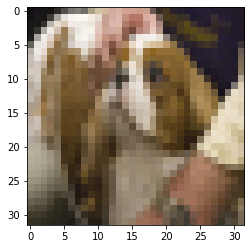

In [221]:
image, label = getRandImg()
plt.imshow(image)
print(val_set.classes[label])

In [222]:
transform = transforms.Compose(
    [
         transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [197]:
prediction_var = Variable((images[0].unsqueeze(0)).cuda(), requires_grad=True)

In [223]:
model = MedT_C().cuda()
model.load_state_dict(load("./outputs/model_latest.pth"))
# model.cuda()

<All keys matched successfully>

In [224]:
with no_grad():
    prediction = model(transform(image))
    predicted_class = np.argmax(prediction)
    print(predicted_class)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [256, 3, 7, 7], but got 3-dimensional input of size [3, 32, 32] instead

In [187]:
class SaveFeatures():
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

In [188]:
final_layer = model._modules.get('encoder')

In [189]:
activated_features = SaveFeatures(final_layer)

In [190]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

<ipython-input-190-5893ac2c4294>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [191]:
topk(pred_probabilities, 10)

torch.return_types.topk(
values=tensor([0.2915, 0.1852, 0.1254, 0.1103, 0.1000, 0.0581, 0.0511, 0.0364, 0.0224,
        0.0196], device='cuda:0'),
indices=tensor([3, 2, 0, 4, 5, 7, 6, 9, 8, 1], device='cuda:0'))

In [106]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [107]:
weight_softmax_params = list(model.decoder._modules.get('decoder').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [108]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0715,  0.2426,  0.1270,  ..., -0.0133,  0.0116,  0.0357],
         [ 0.0379, -0.0616,  0.1888,  ...,  0.2027,  0.1548,  0.0394],
         [-0.1325,  0.0932,  0.0010,  ..., -0.0410, -0.0578, -0.1622],
         ...,
         [-0.1294, -0.1819, -0.1012,  ..., -0.0207, -0.1084, -0.0497],
         [ 0.1440, -0.1212,  0.1124,  ..., -0.1479, -0.0472,  0.1615],
         [-0.0381, -0.0666, -0.1052,  ...,  0.1340, -0.1040,  0.0370]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0659,  0.0356, -0.0289,  0.0257, -0.0072, -0.0434, -0.0306, -0.0260,
         -0.0260, -0.0441], device='cuda:0', requires_grad=True)]

In [109]:
class_idx = topk(pred_probabilities, 1)[1].int()

In [110]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

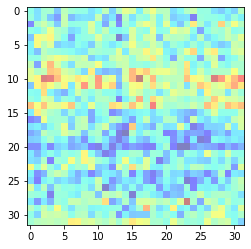

In [111]:
imshow(overlay[0], alpha=0.5, cmap='jet')

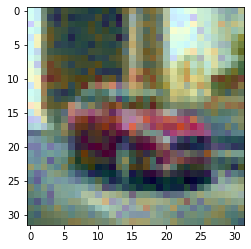

In [112]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.2, cmap='jet')